# How to inject artifical signals into lightcurves

`lightkurve` includes classes to inject artificial signals (e.g. supernovae, planetary transits, rotation, flares) into K2, Kepler, TESS, and potentially ground based light curves. 

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as plt
import numpy as np

Let's download a K2 light curve of a galaxy. Currently, injection works on the light curve level, so we'll need to construct a light curve from the target pixel file.

In [3]:
tpf = KeplerTargetPixelFile.from_archive(220381074)   # A galaxy observed in K2
lc = tpf.to_lightcurve(aperture_mask='all')           # Returns a KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

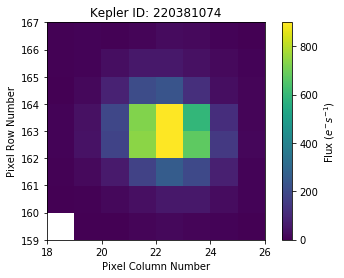

In [4]:
tpf.plot();

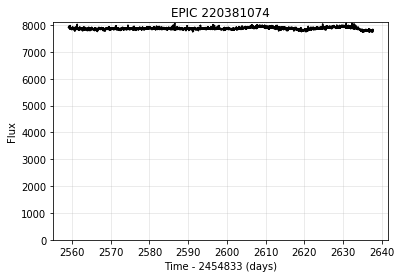

In [5]:
lc.plot(normalize=False);
plt.title('EPIC 220381074')
plt.ylim(0);

The light curve of this galaxy is fairly smooth, with some variability from the spacecraft motion and thermal fluctuations.  Now let's create a supernova model with the new `SupernovaModel` class. You'll need to install [sncosmo](http://sncosmo.readthedocs.io/) for this class to work.

You can specify the source, bandpass, and redshift of the supernova model. These attributes are common to every source.

In [6]:
import lightkurve.injection as inj

The SNcosmo models usually return units of $\rm \frac{photons}{s \; cm^2}$, integrated over the Kepler bandpass.  `lightkurve` automatically translates these physical source units measured on the Kepler's CCD, $\rm \frac{e}{s}$:

$$ f (\mathrm{\frac{e}{s}}) = I(\mathrm{\frac{photons}{s \; cm^2}}) \times A \frac{(\mathrm{cm^2})}{1} \times QE \big(\frac{\mathrm{e}}{\mathrm{photon}}\big)$$

where  
$I$ is the flux intensity received at the Earth,  
$A$ is the light collecting area of Kepler, and  
$QE$ is the (wavelength dependent) quantum effiency of *Kepler* CCDs.

The spectral response that SNcosmos *already includes* the QE as a function of wavelength, so SNcosmo delivers $I$ in units of $\rm \frac{e}{s \; cm^2}$ in this case.  The effective light collecting area of the telescope also includes obscuration and vignetting, which are summarized in Section 3.6 of the Kepler instrument handbook.  Ignoring vignetting we have:

$$A = (1 - 0.227) \times \pi (\frac{0.95 \mathrm{m}}{2})^2 \sim 5480 \; \mathrm{cm^2}$$

In [7]:
A_eff_cm2 = (1 - 0.227) * np.pi * (95/2.0 )**2 #95 cm telescope diameter

The supernova model below is based on the [Hsiao et al. 2007](http://adsabs.harvard.edu/abs/2007ApJ...663.1187H) and takes three parameters: redshift $z$, amplitude, and $t_0$. 
<br>
(Note: depending on the source, $t_0$ may specify the beginning or the peak of the supernova.)
<br>

In [8]:
sn_model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-7)

You can preview the light curve with the `.evaluate` method, which computes the model function at each time point.

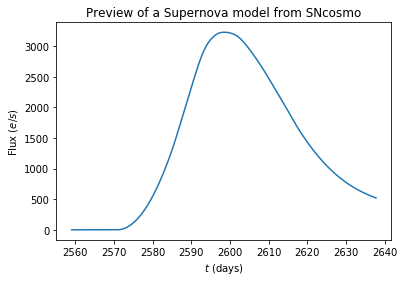

In [9]:
sn_flux = sn_model.evaluate(lc.time)
plt.plot(lc.time, sn_flux)
plt.title('Preview of a Supernova model from SNcosmo')
plt.ylabel('Flux $(e/s)$')
plt.xlabel('$t$ (days)');

Finally, we can inject the supernova model into our K2 light curve using the `.inject` method. We don't need to pre-compute the supernova model, simply pass in the model object will get computed at the same time points as the lightcurve object.  Let's plot the K2 light curve and the injected light curve next to it.

In [10]:
lcinj = inj.inject(lc, sn_model)

TypeError: inject() missing 2 required positional arguments: 'flux_err' and 'model'

NameError: name 'lcinj' is not defined

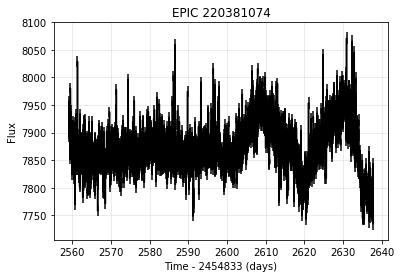

In [11]:
#K2 light curve
lc.plot(normalize=False)
plt.title('EPIC 220381074')

#K2 light curve with injection
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 with Hsiao Supernova Injection');

Success! We injected a supernova light curve into this galaxy.

#### Wide support for supernova models and random model parameter assignment

We automatically support any models that exist in `SNcosmo`.  You can specify the model source with the `source` keyword, and input the model parameters using `kwargs` to `SupernovaModel` in any order. Parameters can also be chosen randomly from a uniform distribution using `inj.UniformDistribution`, or a Gaussian distribution using `inj.GaussianDistribution`. For example, let's simulate a supernova with the SALT2 model, which takes 5 parameters ($t_0$, $z$, $x_0$, $x_1$, and $c$), and choose $z$ randomly from a Gaussian distribution with mean 0.5 and sigma 0.2:

In [12]:
model = inj.SupernovaModel(T0=2600, source='salt2', bandpass='kepler', 
                           z=inj.UniformDistribution(0.3,0.5), x0=2.0e-3, x1=1.e-2, c=-.1)
lcinj = inj.inject(lc, model)
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 with SALT2 Supernova Injection');

TypeError: inject() missing 2 required positional arguments: 'flux_err' and 'model'

Every time you create a new model, a new $z$ will be chosen from this Gaussian distribution, so you can quickly inject supernovae of many $z$ values.

## Examples with planets

We can also use the `.inject` method to inject a planetary transit. Let's download the Kepler light curve of a G-type star:

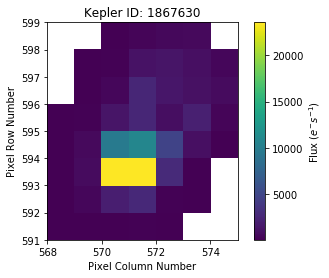

In [13]:
tpf = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

tpf.plot();

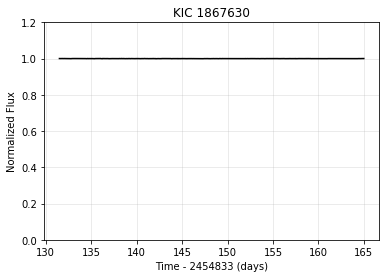

In [14]:
lc.plot();
plt.title('KIC 1867630')
plt.ylim(0, 1.2);

The Kepler light curve of this star is very smooth, but if we zoom in we can see that there is some slight variability: 

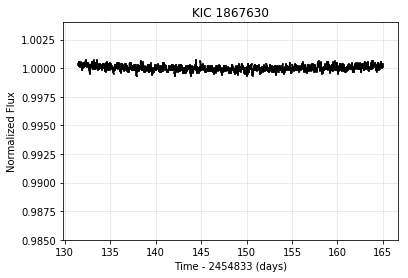

In [15]:
lc.plot();
plt.title('KIC 1867630')
plt.ylim(0.985, 1.004);

Now let's inject a planetary transit into this light curve. We're going to inject a Jupiter-sized planet with an orbital period chosen from a uniform distribution between 4 and 8 days using `TransitModel`.

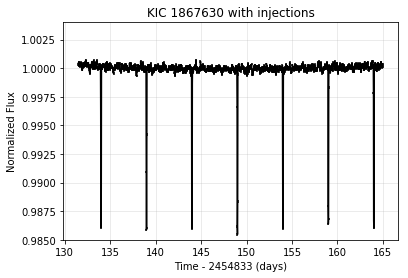

In [44]:
model = inj.TransitModel()
model.add_planet(period=5, T0=134, rprs=.12, a = 15, inc = 87, ecc = 0, w = 90, limb_dark = "nonlinear", u = [0.5, 0.1, 0.1, -0.1])

lc_transit = lc.inject(model)

lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004);

You can inject multiple planets.

(0.985, 1.004)

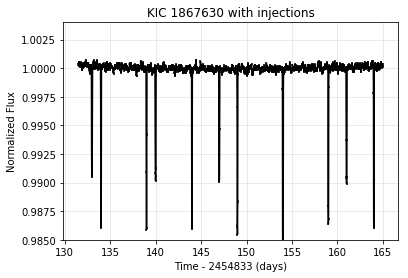

In [46]:
model.add_planet(period=7, T0=133, rprs=.1, a = 15, inc = 87, ecc = 0, w = 90, limb_dark = "nonlinear", u = [0.5, 0.1, 0.1, -0.1])

lc_transit.inject(model)
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)

You can specify the orbital period and radius ratio, but also the impact parameter, eccentricity, stellar density, and limb darkening law, etc.